# 2. MLP基礎 解説
## 概要
本演習ではChapter02で学習した、深層学習の基礎である多層パーセプトロンを穴埋め形式で実装しました。<br>
演習問題文は<font color="Red">赤字</font>で表示されています。


## 回帰モデル演習（スクラッチ）

### データの準備

#### ライブラリのインポート

必要なライブラリをインポートします。エラーになる場合は該当するものをインストールしてください。

In [ ]:
import csv
import cv2
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
%matplotlib inline
# "%matplotlib inline" の代わりに以下のコマンドを使用できる場合、3次元で座標軸を操作可能なプロットを表示することができます。
# %matplotlib notebook


# 乱数シードを指定
np.random.seed(seed=0)

#### データの３次元散布図を作成する関数

データ可視化に使用します。演習の問題とは関係ありませんので読み飛ばしてください。

In [ ]:
def plot_data(data, name='Data Plot'):
    # グラフ作成
    fig = plt.figure()
    ax = Axes3D(fig)

    # 軸ラベルの設定
    ax.set_xlabel("X0-axis")
    ax.set_ylabel("X1-axis")
    ax.set_zlabel("Y-axis")

    # 表示範囲の設定
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(0, 10)

    ax.plot(data[:, 0], data[:, 1], data[:, 2],
            "o", color="#ff2222", ms=2, mew=0.5)
    ax.set_title(name)
    plt.show()

#### データの読み込み

本演習では、train_data.csvを訓練用データ、test_data.csvをテスト用データとして使用します。データはx0, x1, yの3列からなり、以下の式に従っています。

$$ y = \left\{ \begin{array}{ll} (x_0-1)^2 + (x_1-1)^2 & (x_0 \gt 0) \\ (x_0+1)^2 + (x_1+1)^2 & (x_0 \leq 0) \end{array} \right. $$

訓練データ10000個の(x0, x1, y)の組を多層パーセプトロンで学習し、テストデータ2000個の学習におけるコストの推移を観測します。
まずはデータのプロットを表示してみます。

※ここでエラーとなっている場合はライブラリのインポートが完了していないか、正常にデータを読み込めていません。同ディレクトリ内にダウンロードした`train_data.csv`と`test_data.csv`が存在していることを確認してください。

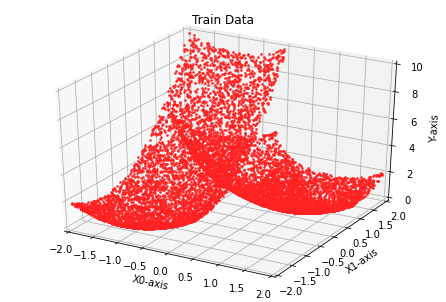

In [ ]:
# データの読み込み
with open('train_data.csv') as f:
    reader = csv.reader(f)
    train_data = np.array([[float(x) for x in row] for row in reader])
with open('test_data.csv') as f:
    reader = csv.reader(f)
    test_data = np.array([[float(x) for x in row] for row in reader])

# 訓練データを可視化
plot_data(train_data, 'Train Data')

#### データの数

訓練時とテスト時で扱うデータ数を確認します。

In [ ]:
N_train = train_data.shape[0]
print('訓練データの数: ', N_train)
N_test = test_data.shape[0]
print('テストデータの数: ', N_test)

訓練データの数:  10000
テストデータの数:  2000


### 活性化関数

#### ReLU関数

* <font color="Red">問1. ReLUを完成させてください。</font>

```
引数:
    x: [N, M] (np.float)
       Nはバッチサイズにあたる
返値:
    [N, M] (np.float)
```

- 以下の式で定義されるrelu関数を実装します。
$$ \text{ReLU}(x) = \left\{ \begin{array}{ll} x & (x \gt 0) \\ 0 & (x \leq 0) \end{array} \right. $$
- 引数`v`の各要素と0の大きい方を取り、`x`とします。
- ヒント: np.maximum()

In [ ]:
def relu(v):
    x = np.maximum(0, v) ### 問1 ###
    return x

#### <font color="Red">問1 解説</font>

ReLu関数とは、ReLu関数の説明変数をvとすると

- v が0より大きい場合は、vを返す
- v が0以下の場合は、0を返す

関数のことをいいます。

そのため、xと0で大きい値を返す関数を作れば良いことが分かります。

今回は、ヒントにも書かれているように、np.maximum()を用いて表してみましょう。

np.maximum()とは、入力した引数の中で最も大きい値を出力してくれる関数です。

例えば

```
np.maximum(1,100)
>>100
```

という風になります。

これを踏まえて、vと0で大きい値を返す関数を作ってみると

```
np.maximum(0, v)
```

となります。

これを用いれば、問1は以下のようになります。

```
def relu(v):
    x = np.maximum(0, v) 
    return x
```

#### softmax関数
* <font color="Red">問2. softmax関数を完成させてください。</font>

```
引数:
    x: [N, M] (np.float)
       Nはバッチサイズにあたる
返値:
    [N, M] (np.float)
```

バッチ計算が可能なsoftmax関数を実装します。<br>
exp関数がオーバーフローすることを防ぐために、各データについて入力信号の最大値を引いて、0以下にします。<br>
    numpyでは```[N, M] - [N]```の計算はブロードキャストができませんので、```x```を転置し```[M, N] - [N]```の形で計算を行ったあと、さらに転置をして元の形に戻します。
$$ \text{Softmax}(x_{ij}) = \frac{\exp (x_{ij}^{\prime})}{\sum_{k}^{M}\exp (x_{ik}^{\prime})} \\ $$
$$    x_{ij}^{\prime} = x_{ij} - max_{j}(x_{ij}) $$

In [ ]:
def softmax(x):
    x = x.T
    x = x - np.max(x, axis=0) ### 問2-1 ###
    print(x)
    print(np.sum(np.exp(x), axis=0))
    x = np.exp(x) / np.sum(np.exp(x), axis=0) ### 問2-2 ###
    return x.T

#### <font color="Red">問2 解説</font>

今回の回答の手順として

<ol>
<li>softmax関数の右辺に入る変数を求める</li>
<li>softmax関数を求める</li>
</ol>

という順序になっております。

まず、１つ目についてですが、今回の実装のヒントになる部分が上記の解説にかかれています。

<b>
numpyでは``` [N, M] - [N] ```の計算はブロードキャストができませんので、``` x ```を転置し``` [M, N] - [N] ```の形で計算を行ったあと、さらに転置をして元の形に戻します。
</b>

これを１行のコードで書くのは難しいため、コードに書きやすい形に分割します。

<ol>
<li>x を転置する</li>
<li>[M, N] - [N]の形計算を行う</li>
</ol>

そして、２つ目の計算を行います。

最後に、転置したものを戻すために、再び転置をすることでもとの形に戻します。

以上の手順に沿ってコードを書くことで、Softmax関数を実装することができます。

まずは、xの転置を行います。

これについては、``` 変数.T ```というコードをかくことで転置を行うことができます。

例を表すと以下のような感じです。

```
x = [[0 1 2]  [3 4 5]]
x = x.T

x
>>>  [[0 3]
      [1 4]
      [2 5]]
```

次に、[M, N] - [N]の形計算についてです。

このコードを書くための鍵となる部分が、どのようにmax（最大値）を表現するか。

これについては、```np.max()```という関数を用いることで、書くことができます。

```np.max()```は、入力した配列の中で１番大きい値を出力してくれる関数です。

また、```np.max(x, axis=0)```の```axis```についてですが、これは「行ごとと列ごと（縦と横）のどちらを対象にするか」を表しています。

```axis```が0の場合は、「行ごと（縦を）みる」、1の場合は、「列ごと（横を）みる」ことを表しています。

今回の場合は、「最大の列はどこか」を取得したいため、```axis = 1```と考えられますが、１点注意が必要なことがあります。それは、「```x```が既に転置されているものである」ということです。

つまり、```axis = 0```とする必要があります。

そして、Softmaxを求めるために必要な変数は作成できたため、Softmaxの式を作り上げていきます。

ここでポイントとなるのが、分母の和（シグマ）の部分。

和については、```np.sum()```を用いることで作成することができます。

exp関数についても、numpyで```np.exp()```と表すことができるため、先程作成した```x```をexp関数に入力した```np.exp(x)```にすることで、```np.sum()```に入力する形は出来上がりました。

次に、「行ごとと列ごと（縦と横）のどちらを対象にするか」を表す```axis```についてです。

今回、シグマの中身を見てみると、列(```k```の部分)が変化していることが分かります。つまり、列の要素の和がシグマの正体であることがわかります。

これだけだと、```axis = 1```となりますが、```x```は一旦転置されているため、```axis = 0```となります。

以上から、Softmax関数は以下のように表すことができます。

```
x = np.exp(x) / np.sum(np.exp(x), axis=0)
```

そして、最後に転置したものを戻すために```x.T```を書き加えることで、Softmax関数を実装することができました。

以上をまとめた結果が以下の通りです。

```
def softmax(x):
    x = x.T
    x = x - np.max(x, axis=0) ### 問2-1 ###
    print(x)
    print(np.sum(np.exp(x), axis=0))
    x = np.exp(x) / np.sum(np.exp(x), axis=0) ### 問2-2 ###
    return x.T
```

#### sigmoid関数
* <font color="Red">問3. sigmoid関数を完成させてください。</font>

```
引数:
    x: [N, M] (np.float)
       Nはバッチサイズにあたる
返値:
    [N, M] (np.float)
```

バッチ計算が可能なsigmoid関数を実装します。<br>

$$   \text{Sigmoid}(x) = \frac{1}{1 + \exp(-x)} $$

In [ ]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x)) ### 問3 ###

#### <font color="Red">問3 解説</font>

Sigmoid関数の公式に沿って書いてみましょう。

関数が必要になってくるのが、分母の部分。

```exp(-x)```の部分については、```np.exp()```関数を用いることで実装できるため、これを使用します。

```-x```が入力されているので、```np.exp()```の中身にはそのまま```-x```を入れましょう。

上記を行ったら、あとは公式に従って必要な部分を埋めていきます。

すると、答えは以下の通りになります。

```
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))
```

#### tanh関数
* <font color="Red">問4. tanh関数を完成させてください。</font>
  * <font color="Red">問4-1. tanh関数の分子にあたるsinh(双曲線正弦関数)の式を記述しましょう。</font>
  * <font color="Red">問4-2. tanh関数の分母にあたるcosh(双曲線余弦関数)の式を記述しましょう。</font>

```
引数:
    x: [N, M] (np.float)
       Nはバッチサイズにあたる
返値:
    [N, M] (np.float)
```

バッチ計算が可能なtanh関数を実装します。<br>
tanh関数は以下のように定義されている。<br>

$$   \text{tanh}(x) = \frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)} $$

tanh関数はハイパボリックタンジェントやタンエイチと読み、sinh関数とcosh関数を用いて以下のように書き直すことができる。

$$   \text{tanh}(x) = \frac{\text{sinh}(x) }{\text{cosh}(x) } $$

sinh関数はハイパボリックサインやシャイン、cosh関数はハイパボリックコサインやコッシュと読み、以下のように定義されている。

$$   \text{sinh}(x) = \frac{\exp(x) - \exp(-x)}{2} $$

$$   \text{cosh}(x) = \frac{\exp(x) + \exp(-x)}{2} $$

In [ ]:
def tanh(x):
    sinh = (np.exp(x) - np.exp(-x)) / 2.0 ### 問4-1 ###
    cosh = (np.exp(x) + np.exp(-x)) / 2.0 ### 問4-2 ###
    return sinh / cosh

#### <font color="Red">問4 解説</font>

tanh関数を完成させるために、sinhとcoshの式の形を知っておく必要があります。

sinh及びcoshについては、以下のように表すことができます。

$$   \text{sinh}(x) = \frac{\exp(x) - \exp(-x)}{2} $$

$$   \text{cosh}(x) = \frac{\exp(x) + \exp(-x)}{2} $$

この公式をもとに、sinh及びcoshについてのコードを書いたものが以下の通りになります。

```
sinh = (np.exp(x) - np.exp(-x)) / 2.0 
```

```
cosh = (np.exp(x) + np.exp(-x)) / 2.0 
```

そして、tanhは

$$   \text{tanh}(x) = \frac{\text{sinh}(x)}{\text{cosh}(x)} $$

で求めることができるため

```return sinh / cosh```

とすれば、完成。

以上の内容をまとめると、次の通りである。

```
def tanh(x):
    sinh = (np.exp(x) - np.exp(-x)) / 2.0 ### 問4-1 ###
    cosh = (np.exp(x) + np.exp(-x)) / 2.0 ### 問4-2 ###
    return sinh / cosh
```

#### Leaky ReLU関数

* <font color="Red">問5. Leaky ReLUを完成させてください。</font>

```
引数:
    x: [N, M] (np.float)
       Nはバッチサイズにあたる
返値:
    [N, M] (np.float)
```

- 以下の式で定義されるLeaky ReLU関数を実装します。

$$ \text{Leaky ReLU}(x,\alpha) = \left\{ \begin{array}{ll} x & (x \gt 0) \\ \alpha x & (x \leq 0) \end{array} \right. $$
- $\alpha$は定数。

In [ ]:
def lrelu(x, alpha=0.01):
    x = np.maximum(alpha*x, x) ### 問5 ###
    return x

#別解
def lrelu(x, alpha=0.01):
    x = np.where(x > 0.0, x, alpha*x)
    return x 

#### <font color="Red">問5 解説</font>

LeakyReLUは

- ```x'''が0より大きければ```x'''を返す
- ```x'''が0以下のときは```αx'''を返す

といった関数である。
これを実装すれば完成する。

最も、シンプルな回答は```np.maximum()```を使って最大値を取得する方法である。

答えは以下の通りである。

```
x = np.maximum(alpha*x, x)
```

また、別解も存在するため紹介する。

別解とは、```np.where()```を使った方法である。

```np.where(引数1,引数2,引数3)```について説明すると

- 引数1を満たしている場合、引数2を実行
- 引数1を満たしていない場合、引数3を実行

といった感じである。

これをLeaky ReLUに当てはめると

- 引数1 : xが0より大きい
- 引数2 : x
- 引数3 : αx

とすれば、```np.where()```を用いて表現できる。

以上まとめると、次のようなコードを書けば良いことが分かる。

```
x = np.where(x > 0.0, x, alpha*x)
```

### コスト関数 平均二乗誤差
以下の式で定義される平均二乗誤差を実装します。出題範囲ではないですが、確認しておいてください。
```
引数:
    t: [N, M] (np.float)
    y: [N, M] (np.float)
       Nはバッチサイズにあたる
返値:
    mse: [M] (np.float)
```


$$
\text{MSE} = \frac{1}{NM} \sum_{i}^{N}\sum_{j}^{M} (t_{ij}-y_{ij})^2
$$
- `t`と`y`の差の2乗の平均を取り、`mse`とします。
- 今回のように、M=1（目的変数が一つ）である場合が多い

In [ ]:
def MSE(t, y):
    mse = np.mean(np.square(t - y))
    return mse

### 多層パーセプトロンの定義

<font color="Red">問6-1~問6-4. MLPクラスの順伝播forward関数を完成させてください。</font>
- 以下の式で定義される順伝播を実装します。(Φは活性化関数)
$$
X_{i+1} = \phi(X_i \cdot W_i + B_i)
$$    
- 第1層`self.layer1`を定義します。入力層`self.layer0`と重み`self.w1`との内積を取り、バイアス`self.b1`を加算します。そして活性化関数`relu`に渡します。
- 第2層`self.layer2`を定義します。第1層`self.layer1`と重み`self.w2`との内積を取り、バイアス`self.b2`を加算します。そして活性化関数`relu`に渡します。
- 第3層`self.layer3`を定義します。第2層`self.layer2`と重み`self.w3`との内積を取り、バイアス`self.b3`を加算します。そして活性化関数`relu`に渡します。
- 出力層`self.out`を定義します。第3層`self.layer3`と重み`self.w4`との内積を取り、バイアス`self.b4`を加算します。
- 出力層では活性化関数Φは使用しないことに注意せよ
- ヒント: np.dot()　もしくは np.matmul()

<font color="Red"> 問6-5~問6-8. MLPクラスの逆伝播によって誤差と勾配を求めるbackward関数を完成させてください。</font>
- 出力層誤差`delta4`を定義します。二乗誤差の微分なので、以下の式に従います。  <br>
$$
\delta_{out} = \frac{d(T-Y)^2}{dY} = -2(T-Y)
$$　
- 誤差逆伝播は以下の式に従います。
$$
\delta_i = \phi'(v_{i+1})*\delta_{i+1} \cdot W_{i+1}^t
$$
$$
\phi'(v_i) = \left\{ \begin{array}{ll} v_i \frac{d}{dv_i} & (v_i \gt 0) \\ 0 \frac{d}{dv_i} & (v_i \leq 0) \end{array} \right. = 
                \left\{ \begin{array}{ll} 1 & (v_i \gt 0) \\ 0 & (v_i \leq 0) \end{array} \right. = 
                    \left\{ \begin{array}{ll} 1 & (x_i \gt 0) \\ 0 & (x_i \leq 0) \end{array} \right.
$$
- 第3層誤差`delta3`を定義します。出力層誤差`delta4`と重み`self.w4`の転置との内積を取ります。
- 第2層誤差`delta2`を定義します。第3層誤差`delta3`と重み`self.w3`の転置との内積を取り、第3層`self.layer3`におけるreluの微分との積を取ります。
- 第1層誤差`delta1`を定義します。第2層誤差`delta2`と重み`self.w2`の転置との内積を取り、第2層`self.layer2`におけるreluの微分との積を取ります。
- ヒント: numpy.dot(), numpy.transpose(), numpy.where()
- ヒント: reluの微分は該当する層の各要素が0より大きいものは1, 0以下のものは0としたベクトルに等しい

In [ ]:
# 回帰モデル
class MLP_regressor():
    '''
    多層パーセプトロン Multi Layered Perceptron
    構成: [入力層, 第1層, 第2層, 第3層, 出力層]
    ノード数: [2, 50, 50, 10, 1]
    '''

    def __init__(self):
        '''
        コンストラクタ
        パラメータ（重みw, バイアスb）の定義
        第1層重み self.w1: [2, 50] 平均0, 標準偏差0.1の乱数
        第2層重み self.w2: [50, 50] 平均0, 標準偏差0.1の乱数
        第3層重み self.w3: [50, 10] 平均0, 標準偏差0.1の乱数
        第4層重み self.w4: [10, 1] 平均0, 標準偏差0.1の乱数
        
        第1層バイアス self.b1: [50] 要素が全て0
        第2層バイアス self.b2: [50] 要素が全て0
        第3層バイアス self.b3: [10] 要素が全て0
        第4層バイアス self.b4: [1] 要素が全て0
        
        numpyの乱数については以下のページを参照
        https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html
        '''
        
        # 重みの定義
        self.w1 = np.random.randn(2, 50) * 0.1
        self.w2 = np.random.randn(50, 50) * 0.1
        self.w3 = np.random.randn(50, 10) * 0.1
        self.w4 = np.random.randn(10, 1) * 0.1

        # バイアスの定義
        self.b1 = np.zeros(50, dtype=float)
        self.b2 = np.zeros(50, dtype=float)
        self.b3 = np.zeros(10, dtype=float)
        self.b4 = np.zeros(1, dtype=float)

    def forward(self, x):
        '''
        順伝播
        入力 x: [N, 2]
        入力層 self.layer0: [N, 2]
        第1層 self.layer1: [N, 50]
        第2層 self.layer2: [N, 50]
        第3層 self.layer3: [N, 10]
        出力層 self.out: [N, 1]
        '''
        
        self.layer0 = x
        self.layer1 = relu(np.dot(self.layer0, self.w1) + self.b1) ### 問6-1 ###
        self.layer2 = relu(np.dot(self.layer1, self.w2) + self.b2) ### 問6-2 ###
        self.layer3 = relu(np.dot(self.layer2, self.w3) + self.b3) ### 問6-3 ###
        self.out = np.dot(self.layer3, self.w4) + self.b4 ### 問6-4 ###
        return self.out

    def backward(self, t, y):
        '''
        逆伝播
        真の値 t: [N, 1]
        予測値 y: [N, 1]
        
        出力層誤差 delta4: [N, 1]
        第3層誤差 delta3: [N, 10]
        第2層誤差 delta2: [N, 50]
        第1層誤差 delta1: [N, 50]
        
        第4層b勾配 dedb4: [N, 1]
        第3層b勾配 dedb3: [N, 10]
        第2層b勾配 dedb2: [N, 50]
        第1層b勾配 dedb1: [N, 50]
        
        第4層w勾配 dedw4: [N, 10, 1]
        第3層w勾配 dedw3: [N, 50, 10]
        第2層w勾配 dedw2: [N, 50, 50]
        第1層w勾配 dedw1: [N, 2, 50]
        '''
        
        # 出力層の誤差デルタは二乗誤差の微分
        delta4 = -2 * (t - y) ### 問6-5 ###
        # 誤差逆伝播
        delta3 = np.dot(delta4, self.w4.transpose()) ### 問6-6 ###
        delta2 = np.dot(delta3 * np.where(self.layer3 > 0, 1., 0.), self.w3.transpose()) ### 問6-7 ###
        delta1 = np.dot(delta2 * np.where(self.layer2 > 0, 1., 0.), self.w2.transpose()) ### 問6-8 ###

        # バイアスbのコスト関数eに対する勾配
        self.dedb4 = np.mean(delta4, axis=0)
        self.dedb3 = np.mean(delta3 * (self.layer3 > 0), axis=0)
        self.dedb2 = np.mean(delta2 * (self.layer2 > 0), axis=0)
        self.dedb1 = np.mean(delta1 * (self.layer1 > 0), axis=0)

        # 重みwのコスト関数eに対する勾配
        self.dedw4 = np.dot(self.layer3.T, delta4) / delta4.shape[0]
        self.dedw3 = np.dot(self.layer2.T, delta3 * (self.layer3 > 0)) / delta3.shape[0]
        self.dedw2 = np.dot(self.layer1.T, delta2 * (self.layer2 > 0)) / delta2.shape[0]
        self.dedw1 = np.dot(self.layer0.T, delta1 * (self.layer1 > 0)) / delta1.shape[0]

    def optimize_GradientDecent(self, lr):
        '''
        勾配降下法によるパラメータの更新
        '''
        self.b1 -= lr * self.dedb1
        self.b2 -= lr * self.dedb2
        self.b3 -= lr * self.dedb3
        self.b4 -= lr * self.dedb4

        self.w1 -= lr * self.dedw1
        self.w2 -= lr * self.dedw2
        self.w3 -= lr * self.dedw3
        self.w4 -= lr * self.dedw4

#### <font color="Red">問6 解説</font>

### 問6-1~6-4

問6-1~6-3までは、数字が異なるのみで、式の形は同じである。

そのため、6-1についてのみ考えることとする。

<b>第1層`self.layer1`を定義します。入力層`self.layer0`と重み`self.w1`との内積を取り、バイアス`self.b1`を加算します。そして活性化関数`relu`に渡します。</b>

上記を式で表すと

$$ layer1 = \text{ReLU}(layer0 \cdot w1 + b1) $$    

と表すことができます。

従って、これをコードに書いていけば良いです。

また、内積については```np.dot()```を用いることで、入力した２つの引数の内積を求めることができます。

なお、ReLU関数は既に実装されているものがあるので、それを利用しちゃいましょう。

ということで、6-1の答えは以下の通りになります。

```
self.layer1 = relu(np.dot(self.layer0, self.w1) + self.b1)
```

また、6-2、6-3についても6-1と同じ要領でコードを書くことができます。

layer1では、layer0を入力することで求めることができました。

そのため、layer2ではlayer1の出力、layer3ではlayer2の出力を使用することで求めることができます。

解説文を参考にしてコードを書くと、以下のようになります。

```
self.layer2 = relu(np.dot(self.layer1, self.w2) + self.b2) ### 問6-2 ###
self.layer3 = relu(np.dot(self.layer2, self.w3) + self.b3) ### 問6-3 ###
```

次に、6-4についてですが、活性化関数を使用しない点がこれまでの問題との違いとなります。そのため、ReLU関数に入力しないのが答えとなるため

```
self.out = np.dot(self.layer3, self.w4) + self.b4
```

のようにすれば、正解です。

### 問6-5~6-8

まず、問6-5です。

上記の解説に載っている公式に従うと

```
delta4 = -2 * (t - y)
```

となります。

次に、問6-6です。

問6-6に該当する部分に着目すると、

<b>第3層誤差delta3を定義します。出力層誤差delta4と重みself.w4の転置との内積を取ります。</b>

と書かれています。

転置については、```transpose()```という関数を用いることで行うことができます。

以上より、転置と内積の関数を用いることで

```
delta3 = np.dot(delta4, self.w4.transpose())
```

と表現することができます。

次についてですが、問6-7と問6-8で実装すべき形が同じであるため、同時に解説いたします。

問6-7に該当する部分に着目すると、

<b>第2層誤差delta2を定義します。第3層誤差delta3と重みself.w3の転置との内積を取り、第3層self.layer3におけるreluの微分との積を取ります。</b>

上記の文章を式で表すと次の通りになります。

$$ \text{delta2} = \text{delta3}  * \text{ReLU-Differential}(\text{layer3}) \cdot \text{w3}^{\prime} $$    

またReLUの微分は次のとおりです。

$$ \text{ReLU-Differential}(x) = \left\{ \begin{array}{ll} 1 & (x \gt 0) \\ 0 & (x \leq 0) \end{array} \right. $$

上記より、第3層self.layer3におけるreluの微分は次の通りに表すことができる。

```
np.where(self.layer2 > 0, 1., 0.)
```

この部分が分かれば、残りについてはこれまで書いてきたコードの内容を駆使することで作成できる。

従って、問6-7については、以下の通りになります。

```
delta2 = np.dot(delta3 * np.where(self.layer3 > 0, 1., 0.), self.w3.transpose())
```

また、問6-8も文章を式に表すと次の通りになります。

$$ \text{delta1} = \text{delta2}  * \text{ReLU-Differential}(\text{layer2}) \cdot \text{w2}^{\prime} $$

これに従って書くことで、次のようなコードが答えとなります。

```
delta1 = np.dot(delta2 * np.where(self.layer2 > 0, 1., 0.), self.w2.transpose())
```

### 学習

以下ではこれまでで定義した多層パーセプトロンを使用し、データを学習します。
コストが正常に減少し、500epochで0.5以下にまで到達していれば学習は成功していると言えます。

In [ ]:
# モデルの定義
model = MLP_regressor()

# 学習率
lr = 0.01
# 学習エポック数
n_epoch = 500

x_train = train_data[:, 0:2]
t_train = train_data[:, 2:3]
x_test = test_data[:, 0:2]
t_test = test_data[:, 2:3]

# n_epoch繰り返す
for n in range(n_epoch):
    # 訓練
    # Chapter02範囲外のため、ミニバッチは使用しない
    y = model.forward(x_train)
    train_loss = MSE(t_train, y)
    model.backward(t_train, y)
    model.optimize_GradientDecent(lr)

    # テスト
    y = model.forward(x_test)
    test_loss = MSE(t_test, y)

    print('EPOCH ', n + 1, ' | TRAIN LOSS ',
          train_loss, ' | TEST LOSS ', test_loss)
regression_loss = test_loss

EPOCH  1  | TRAIN LOSS  13.60269194677772  | TEST LOSS  13.64726861759201
EPOCH  2  | TRAIN LOSS  13.319505193014443  | TEST LOSS  13.372675701793797
EPOCH  3  | TRAIN LOSS  13.048938105519074  | TEST LOSS  13.109758511569227
EPOCH  4  | TRAIN LOSS  12.790001450371227  | TEST LOSS  12.85790982805296
EPOCH  5  | TRAIN LOSS  12.542041238525556  | TEST LOSS  12.616600401846968
EPOCH  6  | TRAIN LOSS  12.304548642420967  | TEST LOSS  12.385341253456644
EPOCH  7  | TRAIN LOSS  12.077025937993978  | TEST LOSS  12.163531021941013
EPOCH  8  | TRAIN LOSS  11.85884692551945  | TEST LOSS  11.95057313076331
EPOCH  9  | TRAIN LOSS  11.649441032528197  | TEST LOSS  11.746002136518426
EPOCH  10  | TRAIN LOSS  11.448321293979054  | TEST LOSS  11.54939919402566
EPOCH  11  | TRAIN LOSS  11.255029341422683  | TEST LOSS  11.360293805132155
EPOCH  12  | TRAIN LOSS  11.069173397280359  | TEST LOSS  11.178212638230432
EPOCH  13  | TRAIN LOSS  10.890271855526548  | TEST LOSS  11.002654305768727
EPOCH  14  | T

### 予測データの散布図

予測値の散布図と訓練データの散布図を比較してみましょう。

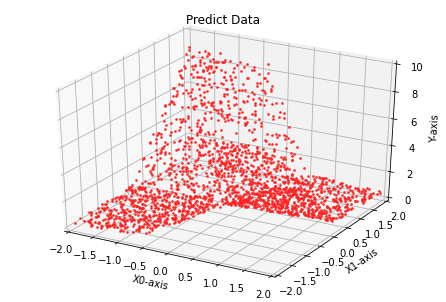

In [ ]:
y = model.forward(x_test)
predict_data = np.concatenate([x_test, y], axis=1)
plot_data(predict_data, 'Predict Data')

## 分類モデル演習（スクラッチ）

---

### データ準備

回帰モデル演習では層ごとに変数を定義し全計算を実装しましたが、分類モデル演習ではクラスと計算グラフを利用し、より汎用的なモデルを設計します。

#### データの読み込み
本演習では、MNISTを使用し、全結合ネットワークで手書き数字の画像の10分類を行います。

今回はデータセットとして、"MNIST"を用います。

"MNIST"は0~9の手書き数字が画像になった画像データと書かれた数字の正解ラベルで構成されており、チュートリアルでよく使われています。データセット全体は70000件で構成されています。

`sklearn`の`train_test_split`を用いてMNISTデータを訓練データとテストデータに分割します。

引数`test_size=0.2`と指定することで、訓練データ:テストデータ = 8:2 に分割することが出来ます。

データは 1チャンネル 28×28 の配列となっています。


In [ ]:
# mnistデータセットのロード(ネットワーク接続が必要・少し時間がかかります)
mnist = datasets.fetch_openml('mnist_784', as_frame=False)
# 画像とラベルを取得
X, T = mnist.data, mnist.target
# 訓練データとテストデータに分割
X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.2)

In [ ]:
# ラベルデータをint型にし、one-hot-vectorに変換します
T_train = np.eye(10)[T_train.astype("int")]
T_test = np.eye(10)[T_test.astype("int")]

#### one-hot-vectorとは？
たとえば$a$が，0~9の整数のみを含むベクトルだとわかっている時に、各要素を数字に該当する列の要素のみが1、その他が0となるようなベクトルにする。
$$
\begin{equation*}
a=
\begin{pmatrix}
1\\
8\\
4\\
2\\
0
\end{pmatrix}\to
a\_onehot = 
\begin{pmatrix}
0, 1, 0, 0, 0, 0, 0, 0, 0, 0\\
0, 0, 0, 0, 0, 0, 0, 0, 1, 0\\
0, 0, 0, 0, 1, 0, 0, 0, 0, 0\\
0, 0, 1, 0, 0, 0, 0, 0, 0, 0\\
1, 0, 0, 0, 0, 0, 0, 0, 0, 0
\end{pmatrix}
\end{equation*}
$$
学習する正解ラベルデータは，one-hot-vectorで表されることが多い．

#### データのサンプリング
画像・ラベルデータをランダムにいくつか取り出して可視化します。
画像は784要素の1次元ベクトルとしてXに格納されていますが、画像として表示するときは28x28の二次元にreshapeします。

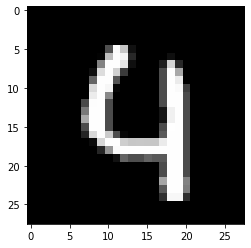

Label:  4


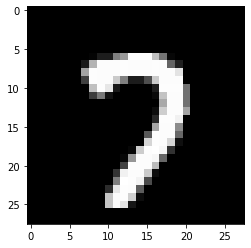

Label:  7


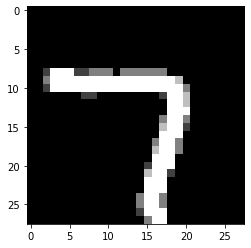

Label:  7


In [ ]:
# テストデータをランダムサンプリング
perm = np.random.permutation(len(X_test))
# サンプル画像を表示する
plt.gray()
for i in perm[:3]:
    plt.imshow(X_test[perm[i]].reshape(28, 28))
    plt.show()
    print('Label: ', np.argmax(T_test[perm[i]]))

### 多層パーセプトロンの定義

#### クロスエントロピー誤差
以下の式で定義される平均二乗誤差を実装します。出題範囲ではないですが、確認しておいてください。<br>
```
引数:
    t: [N, M] (np.float)
    y: [N, M] (np.float)
返値:
    error: (np.float)
```

```y == 0```のときlog関数が破綻しないよう、$ y $ に小さな値 $ \delta = 10^{-8}$ を加算します。
error は 以下の式に従います。
$$ error = -\frac {1}{N} \sum_{i}^{N} {t_i * \log{(y_i + \delta)}} $$

In [ ]:
def cross_entropy_error(t, y):
    delta = 1e-8
    error = -np.mean(t * np.log(y + delta))
    return error

#### ソフトマックスクロスエントロピー誤差
ソフトマックスクロスエントロピー誤差のクラスを実装します。出題範囲ではないですが、確認しておいてください。<br>
順伝播```__call__(self, t, y)```ではyのソフトマックスを取り、tとのクロスエントロピー誤差を返します。その際にyとtをインスタンス変数self.yとself.tに記憶します。関数名を```__call__```としているのは、**関数オブジェクト**を作ることで"インスタンス名()"で順伝播を呼び出せるようにするためです。<br>
逆伝播```backward(self)```では、順伝播で記憶されたself.yとself.tを使用して誤差に対するyの勾配dyを計算します。<br>
yの勾配は以下の式に従います。<br>
※コードの```dy```と式の$ dy $は意味が異なり、```dy``` = $ \frac {dL(t, y)}{dy} $であることに注意してください。
$$ \frac {dL(t, y)}{dy} = y - t $$
また、以降の計算ではバッチの平均を取るため、dyはバッチサイズで割ってから返します。

In [ ]:
class SoftmaxCrossEntropyLoss():
    def __init__(self):
        self.y = None
        self.t = None
        self.loss = None
        
    def __call__(self, t, y):
        self.y = softmax(y)
        self.t = t.copy()
        self.loss = cross_entropy_error(self.t, self.y)
        return self.loss
    
    def backward(self):
        batch_size = self.t.shape[0]
        dy = self.y - self.t
        dy /= batch_size
        return dy

#### 全結合層

```
インスタンス変数:
    self.w: [M, L] (np.float)
            層の重み。正規分布で初期化。
    self.b: [L] (np.float)
            層のバイアス。ゼロで初期化。
    self.x: [N, M] (np.float)
            層の入力信号を記録。Nはバッチサイズ。
    self.dw: [M, L] (np.float)
            層の重みの勾配
    self.db: [L] (np.float)
            層のバイアスの勾配
            
__call__(self, x):
    引数:
        x: [N, M] (np.float)
            入力信号
    返値:
        out: [N, L] (np.float)
            出力信号

backward(self, dout):
    引数:
        dout: [N, L] (np.float)
            出力信号の勾配
    返値:
        dx: [N, M] (np.float)
            入力信号の勾配
        
```
順伝播```__call__(self, x)```は入力信号xを層の重み```self.w```とバイアス```self.b```でアフィン変換し出力とします。
計算は以下の式に従います。
$$ \text{Affine}(x) = out = x \cdot w + b $$
逆伝播```backward(self, dout)```は出力側の勾配[L, M]を入力側に逆伝播させます。入力の勾配```dx```、重みの勾配```dw```、バイアスの勾配```db```それぞれを計算し、```dx```を返します。
計算は以下の式に従います。

$$ 
\begin{align}
\text{grad}(x_{ij}) &= \sum_{k} \text{grad}(out_{ik}) \frac{dout_{ik}}{dx_{ij}} \\
\text{grad}(x_{ij}) &= \sum_{k}\text{grad}(out_{ik})w_{jk} \\
\text{grad}(x) &= \text{grad}(out) \cdot w^T \\ \space \\
\end{align}
$$ 

$$ 
\begin{align}
\text{grad}(w_{jk}) &= \sum_{i} \text{grad}(out_{ik}) \frac{dout_{ik}}{dw_{jk}} \\
\text{grad}(w_{jk}) &= \sum_{i} \text{grad}(out_{ik})x_{ij} \\
\text{grad}(w) &= x^T \cdot \text{grad}(out) \\ \space \\
\end{align}
$$

$$ 
\begin{align}
\text{grad}(b_{k}) &= \sum_{i} \text{grad}(out_{ik}) \frac{dout_{ik}}{db_{k}} \\
\text{grad}(b) &= \sum_{i} \text{grad}(out_{i}) 
\end{align}
$$


    
実装コードでは$ \text{grad}(x) $ = ```dx```, $ \text{grad}(w) $ = ```dw```, $ \text{grad}(b) $ = ```db```と命名されています。 

* <font color="Red">問7. 全結合層クラスを完成させてください。</font>
  * <font color="Red">問7-1. self.x, self.w, self.bの3つの変数を用いて順伝播の出力式を記述してください。</font>
  * <font color="Red">問7-2. 出力信号の勾配doutとself.wを用いて入力信号の勾配を算出する式を記述しましょう。</font>
  * <font color="Red">問7-3. 逆伝播に使う勾配self.dwを算出する式を記述しましょう。</font>
  * <font color="Red">問7-4. 逆伝播に使う勾配self.dbを算出する式を記述しましょう。</font>

In [ ]:
class FullyConnectedLayer():
    def __init__(self, input_shape, output_shape):
        self.w = np.random.randn(input_shape, output_shape) * 0.01
        self.b = np.zeros(output_shape, dtype=np.float)
        self.x = None
        self.dw = None
        self.db = None
        
    def __call__(self, x):
        self.x = x
        out = np.dot(self.x, self.w) + self.b  ### 問7-1 ###
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.w.T) ### 問7-2 ###
        batch_size = dx.shape[0]
        self.dw = np.dot(self.x.T, dout) ### 問7-3 ###
        self.db = np.sum(dout, axis=0) ### 問7-4 ###
        return dx

#### <font color="Red">問7 解説</font>

まず、問7-1についてです・順伝播の出力式は以下の通りです。

$$ x \cdot w + b $$

pythonでの内積の表現方法は今までの問題で説明したものを用います。従って、答えは

```
out = np.dot(self.x, self.w) + self.b
```

となります。

次に問7-2についてです。

全結合層の解説を参考にすると、入力信号を算出する式は以下の通りになります。

$$ \text{dout} \cdot w^T $$

この式をコードで表現すると以下のようになります

```
dx = np.dot(dout, self.w.T)
# dxとおく
```

そして、問7-3については、問7-2と同じように考えるとself.dwを算出する式は以下の通りになります。

$$ x^T \cdot \text{dout} $$

この式をコードで表現すると以下のようになります。

```
self.dw = np.dot(self.x.T, dout)
```

最後に問7-4です。self.dbを算出する式は以下の通りになります。

$$ \sum_{i} \text{grad}(out_{i}) $$

また、

$$ \text{dout} = [out_{1},out_{2},...,out_{n}] $$

* n : doutの要素数

であることから、配列の合計を求められるライブラリ```np.sum```を用いることで表現できます。従って、答えは以下の通りになります。

```
np.sum(dout, axis=0)
# axis = 0は行ごとにみているため
```

#### ReLUクラス

```
インスタンス変数:
    self.mask: [N, M] np.bool
               マスクされるxのフラッグ
               
__call__(self, x):
    引数:
        x: [N, M] np.float
    返値:
        out: [N, M] np.float

backward(self, dout):
    引数:
        dout: [N, M] np.float
    返値:
        dx: [N, M] np.float
    
```

ReLUの順伝播と逆伝播をクラスで実装します。
順伝播```__call__(self, x)```は入力信号xに対して、```x <= 0```部分が1、それ以外は0となるようなマトリックスself.maskを定義します。numpy配列の**ブールインデックス参照**を利用し、xのマスク部を0に変換し返します。
逆伝播```backward(self, dout)```は出力信号の勾配doutの保存されたマスク部を0に変換し、dxとして入力信号の勾配を返します。

* <font color="Red">問8. ReLUクラスを完成させてください。</font>
  * <font color="Red">問8-1. マスク部のフラグであるself.maskを用いて、xのマスク部を0に変換する式を記述しましょう。</font>
  * <font color="Red">問8-2. マスク部のフラグであるself.maskを用いて、出力信号の勾配doutのマスク部を0に変換する式を記述しましょう。</font>

In [ ]:
class ReLU():
    def __init__(self):
        self.mask = None

    def __call__(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0 ### 問8-1 ###
        return out

    def backward(self, dout):
        dout[self.mask] = 0 ### 問8-2 ###
        dx = dout

        return dx

#### <font color="Red">問8 解説</font>

まず、マスク部については、```self.mask = (x <= 0)```によって定義されています。

これは、```x <= 0```の部分を「True（xが0より小さい）」というものを表している部分です。

例えば、```x```を以下のように定義したとします。

$$x=\left(
\begin{array}{cc} 
1 & 0 \\ -1 & 5 
\end{array}
\right)$$

この場合、```mask = (x <= 0)```を考慮すると、```mask```は以下の通りになります。

$$mask=\left(
\begin{array}{cc} 
False & True \\ True & False 
\end{array}
\right)$$

また、```x[mask] = 0```というコードは、```mask```がTrueの部分に対してその後の処理を反映するという操作になります。

そのため、```x[mask]```は以下のようになります。

$$x[mask]=\left(
\begin{array}{cc} 
1 & 0 \\ 0 & -5 
\end{array}
\right)$$

ここまでは、maskについての説明を行って参りました。

従って、これを用いることで問8-1と問8-2について記述することができます。

問8-1については、答えは以下の通りになります。

```
out[self.mask] = 0
```

上記のコードは、```seld.mask```という配列の中で「True」を持つインデックス番号の対象となる```out```の要素を0にするといった意味を持ちます。

また、これを用いることで、問8-2の答えも導くことができます。

```
dout[self.mask] = 0
```

#### Sigmoidクラス

```
インスタンス変数:
    self.out: [N, M] np.float
               
__call__(self, x):
    引数:
        x: [N, M] np.float
    返値:
        out: [N, M] np.float

backward(self, dout):
    引数:
        dout: [N, M] np.float
    返値:
        dx: [N, M] np.float
    
```

Sigmoidの順伝播と逆伝播をクラスで実装します。
順伝播```__call__(self, x)```
は入力信号xに対して、```sigmoid(x)```計算します。\
逆伝播```backward(self, dout)```は出力信号の勾配doutに対して、以下の計算を施すことでdxとして入力信号の勾配を返します。
$$ \frac {dL}{dx} = \frac {dL}{dy} y(1-y)$$

* <font color="Red">問9. Sigmoidクラスを完成させてください。</font>
  * <font color="Red">問9-1. 問3で実装したsigmoid関数を用いて、入力信号xに対してsigmoid(x)を記述しましょう。</font>
  * <font color="Red">問9-2. 出力信号の勾配doutとSigmoid関数の勾配(上式)を用いて、入力信号の勾配dxを記述しましょう。</font>

In [ ]:
class Sigmoid():
    def __init__(self):
        self.out = None

    def __call__(self, x):
        out = sigmoid(x) ### 問9-1 ###
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out ### 問9-2 ###

        return dx

#### <font color="Red">問9 解説</font>

まず、問題9-1についてです。

問題3で以下のような関数を定義しました。

```
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x)) 
```

そのため、この関数をすることで、信号```x```を```sigmoid```の式に入力することができます。

答えを```out```とすると、次のようになります。

```
out = sigmoid(x)
```

次に、問9-2についてです、

上記で説明した式$\frac {dL}{dx} = \frac {dL}{dy} y(1-y)$を利用します。

このとき、$ \frac {dL}{dy}$は勾配```dout```、$y$はsigmoid関数で得られた値```self.out```がそれぞれ該当します。

以上より、```dx```を答えとすると、次のようになります。

```
dx = dout * (1.0 - self.out) * self.out
```

#### Tanhクラス

```
インスタンス変数:
    self.out: [N, M] np.float
               
__call__(self, x):
    引数:
        x: [N, M] np.float
    返値:
        out: [N, M] np.float

backward(self, dout):
    引数:
        dout: [N, M] np.float
    返値:
        dx: [N, M] np.float
    
```

Tanhの順伝播と逆伝播をクラスで実装します。
順伝播```__call__(self, x)```
は入力信号xに対して、```tanh(x)```計算します。\
逆伝播```backward(self, dout)```は出力信号の勾配doutに対して、以下の計算を施すことでdxとして入力信号の勾配を返します。
\begin{align}
\frac {dL}{dx} &= \frac {dL}{dy} \frac {4}{(e^x + e^{-x})^2}\\
&=\frac {dL}{dy} \frac {1}{\text{cosh}^2x}
\end{align}

ここでは、$ \text{cosh} x$という関数が使われているが、ハイパボリックコサインといい。双曲線関数の1つで以下のような関数である。
$$ \text{cosh} x = \frac {e^x + e^{-x}}{2}$$ 

* <font color="Red">問10. Tanhクラスを完成させてください。</font>
  * <font color="Red">問10-1. 問4で実装したtanh関数を用いて、入力信号xに対してsigmoid(x)を記述しましょう。</font>
  * <font color="Red">問10-2. 出力信号の勾配doutとTanh関数の勾配(上式)を用いて、入力信号の勾配dxを記述しましょう。</font>

In [ ]:
class Tanh():
    def __init__(self):
        self.out = None

    def __call__(self, x):
        out = tanh(x) ### 問10-1 ###
        self.x = x
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * 1 / np.cosh(self.x)**2 ### 問10-2 ###

        return dx

#### <font color="Red">問10 解説</font>

まず、問題10-1についてです。

こちらは、問4で実装したtanh関数を利用します。問4では以下のような関数を実装しました。

```
def tanh(x):
    sinh = (np.exp(x) - np.exp(-x)) / 2.0 ### 問4-1 ###
    cosh = (np.exp(x) + np.exp(-x)) / 2.0 ### 問4-2 ###
    return sinh / cosh
```

従って、信号```x```に```tanh```関数を入力することで、出力値を取得することができます。

よって、答えを```out```とすると、次の通りになります。

```
out = tanh(x) 
```

次に問題10-2についてです。

上記で説明した通り、$\frac {dL}{dy} \frac {1}{\text{cosh}^2x}$を実装します。

ここで、$\frac {dL}{dy}$は、```dout```、$x$は```self.x```がそれぞれ概要します。

従って、答えを```dx```とすると、次の通りになります。

```
dx = dout * 1 / np.cosh(self.x)**2
```

#### Leaky ReLUクラス

```
インスタンス変数:
    self.mask: [N, M] np.bool
               マスクされるxのフラッグ
               
__call__(self, x, alpha=0.01):
    引数:
        x: [N, M] np.float
    返値:
        out: [N, M] np.float

backward(self, dout):
    引数:
        dout: [N, M] np.float
    返値:
        dx: [N, M] np.float
    
```

Leaky ReLUの順伝播と逆伝播をクラスで実装します。
順伝播```__call__(self, x)```は入力信号xに対して、```x <= 0```部分が1、それ以外は0となるようなマトリックスself.maskを定義します。numpy配列の**ブールインデックス参照**を利用し、xのマスク部にalphaを掛け算を施します。
逆伝播```backward(self, dout)```は出力信号の勾配doutの保存されたマスク部をalphaに変換し、dxとして入力信号の勾配を返します。

* <font color="Red">問11. Leaky ReLUクラスを完成させてください。</font>
  * <font color="Red">問11-1. マスク部のフラグであるself.maskを用いて、xのマスク部をalpha倍する式を記述しましょう。</font>
  * <font color="Red">問11-2. マスク部のフラグであるself.maskを用いて、出力信号の勾配doutのマスク部をalpha倍する式を記述しましょう。</font>

In [ ]:
class Leaky_ReLU():
    def __init__(self, alpha=0.01):
        self.mask = None
        self.alpha = alpha

    def __call__(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] *= self.alpha ### 問11-1 ###
        return out

    def backward(self, dout):
        dout[self.mask] *= self.alpha ### 問11-2 ###
        dx = dout

        return dx

#### <font color="Red">問11 解説</font>

マスクについては、問8で説明しました。

問11-1ではまず、```out```という変数が持つ値のうち、条件に該当する部分（```self.mask```がTrueの部分）を定義します。これについては、```out[self.mask]```と表すことができます。

次に、条件に当てはまる部分を```alpha```倍するコードを実装します。これについては、次のように表せます。

```
out[self.mask] = out[self.mask] * self.alpha
```

ちなみに、これには別解があります。```out[self.mask]```を一回のみ使い、表現する方法です。次の通りになります。

```
out[self.mask] *= self.alpha
```

どちらも、実装したい内容は同じです。好みにあった方を使うようにしましょう。

次に、問11-2についてです。

行う要領は問11-1と同じです。```dout```という変数が持つ値のうち、条件に該当する部分（```self.mask```がTrueの部分）を定義し、条件に当てはまる部分を```alpha```倍します。

これについては、次のように表すことができます。

```
dout[self.mask] = dout[self.mask] * self.alpha
```

また、同じように別解として次のように表すことができます。

```
dout[self.mask] *= self.alpha
```


---

#### モデルの構築

これまで各種の層をクラスで定義できましたので、ここではそれらを組み合わせることでモデルを簡単に設計することができます。問題にはなっていませんが、コードからモデルの構築の全体像を把握しましょう。

In [ ]:
class MLP_classifier():

    def __init__(self):
        '''
        構造
        x -> fc(784, 256) -> relu -> fc(256, 256) -> relu -> fc(256, 10) -> out
        '''
        
        # 層の定義
        self.fc1 = FullyConnectedLayer(784, 256)
        self.relu1 = ReLU()
        self.fc2 = FullyConnectedLayer(256, 256)
        self.relu2 = ReLU()
        self.fc3 = FullyConnectedLayer(256, 10)
        self.out = None
        
        # 損失関数の定義
        self.criterion = SoftmaxCrossEntropyLoss()

    def forward(self, x):
        '''
        順伝播
        '''
        
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        self.out = self.fc3(x)
        
        # 勾配計算の都合上softmaxはこの順伝播関数内では行わない
        # 予測するときはさらにsoftmaxを通す必要がある
        return self.out

    def backward(self, t):
        '''
        逆伝播
        '''
        
        # 誤差を計算
        loss = self.criterion(t, self.out)
        # 勾配を逆伝播
        d = self.criterion.backward()
        d = self.fc3.backward(d)
        d = self.relu2.backward(d)
        d = self.fc2.backward(d)
        d = self.relu1.backward(d)
        d = self.fc1.backward(d)
        
        return loss

    def optimize_GradientDecent(self, lr):
        '''
        勾配降下法による全層のパラメータの更新
        '''
        for fc in [self.fc1, self.fc2, self.fc3]:
            fc.w -= lr * fc.dw
            fc.b -= lr * fc.db
        

### 学習

20epochで分類精度が80%以上になっていれば学習は成功していると言えます。

In [ ]:
# モデルの宣言
model = MLP_classifier()

# 学習率
lr = 0.005
# 学習エポック数
n_epoch = 20

# n_epoch繰り返す
for n in range(n_epoch):
    # 訓練
    # Chapter02範囲外のため、ミニバッチは使用しない
    y = model.forward(X_train)
    loss = model.backward(T_train)
    model.optimize_GradientDecent(lr)
    
    # テスト
    y = model.forward(X_test)
    test_loss = model.backward(T_test)
    pred = softmax(y)
    accuracy = np.mean(np.equal(np.argmax(y, axis=1), np.argmax(T_test, axis=1)))
    print(f'EPOCH {n + 1} | TRAIN LOSS {loss:.5f} | TEST LOSS {test_loss:.5f} | ACCURACY {accuracy:.2%}')
classification_accuracy = accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


[[-0.29562539 -0.76206684 -0.93177895 ... -0.61730869 -0.58195973
  -0.94082476]
 [ 0.         -0.55708947 -0.49601979 ... -0.41056491 -0.23943193
   0.        ]
 [-0.17327154 -0.41745303 -0.20827776 ... -0.28768509 -0.42552376
  -0.57611108]
 ...
 [-0.08913696 -0.42149041 -0.4869086  ... -0.41583901 -0.44899871
  -0.82725013]
 [-0.21851883 -0.95717305 -1.08961955 ... -0.52023963 -0.60284632
  -1.15442686]
 [-0.23548288 -0.76403983 -0.58754048 ... -0.68671409 -0.93608942
  -0.92216362]]
[8.67233617 6.21853712 6.55175456 ... 6.99810987 6.52464961 5.22609877]
[[-0.2792945  -0.32720125 -0.64111548 ... -0.45033473 -0.47342155
  -0.31412446]
 [-0.43621841 -0.83368136 -0.43195888 ... -0.33834113 -0.57277486
   0.        ]
 [-0.07844195 -0.16123973 -0.05184297 ... -0.10193826  0.
  -0.11377821]
 ...
 [ 0.         -0.4873467  -0.17654674 ... -0.31469575 -0.46241817
  -0.43002424]
 [-0.64755241 -0.7448865  -0.38103712 ... -0.30125921 -0.43561637
  -0.11624257]
 [-0.37789187 -0.69599605 -0.65409

## 提出可否

In [ ]:
print("大問1 回帰ロス: ", regression_loss)
print("大問2 分類精度: ", classification_accuracy)
pass0 = regression_loss < 0.5
pass1 = classification_accuracy > 0.8
if pass0 and pass1:
    print("回帰モデルと分類モデルどちらも学習が成功しているので、提出可能です。")
else:
    if not pass0:
        print("回帰モデル（大問１）の学習が成功していません。")
    if not pass1:
        print("分類モデル（大問２）の学習が成功していません。")
    print("回答を訂正してください。")

大問1 回帰ロス:  0.41781815081421253
大問2 分類精度:  0.8254285714285714
回帰モデルと分類モデルどちらも学習が成功しているので、提出可能です。


## 補足

- 今演習では簡単のため、ミニバッチ学習・重み減衰などの正則化・より高度な最適化・データ拡張など、以降のchapterで学習する手法を使用していません。これらを使用すれば、全結合層でもmnist手書き数字の認識精度を大きく上げることが可能です。
    - 例えばミニバッチを簡単に導入するだけで、20epochで97%以上の精度に達します。

- 更に、今回のMLP_classifierはReLU以外の活性化関数のクラスでも実装可能です。しかしながら、SigmoidやTanhなどを活性化関数を利用すると学習が不安定になるため、精度が十分に上がりません。
    - これらの活性化関数に関しては、ミニバッチなどを導入することで改善できます。
    - また、今回のモデルにおいてもSigmoidを用いて精度を上げたい場合は```lr = 0.25```かつ```n_epoch = 200```程度に設定すると70〜90％程度の精度を出すことができます。